# ROI Presence Used Area overlap

Plots for used cells the amount of average area overlap per cell, based on the generated template image (histogram)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gcsfs, pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from vr2p import styles

# Main Parameters

In [2]:
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
bin_size = 10

# Collect matched cell data.

This only uses clustered rois that passed the 'minimum presence'  test

In [3]:
def collect_masks(animal):
    fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
    with fs.open(f'gs://linear-2ac/registration/match-Tyche-{animal}.pkl', 'rb') as handle:
        matched_masks, matched_im, template_masks, template_im = pickle.load(handle)
    return {'animal':animal,'num_sessions': len(matched_im), 'matched_masks':matched_masks, 
            'matched_im':matched_im,'template_masks':template_masks,
            'template_im':template_im}
matched_info = [ collect_masks(animal) for animal in tqdm(animals)]

  0%|          | 0/11 [00:00<?, ?it/s]

# Collect hist data.

Note if animal does not have enough sessions to get data in one bin then it is ignored for that bin.

In [4]:
from itertools import permutations

data = []
for info in tqdm(matched_info):
    for template in info['template_masks']:
        mask_id = template['id']
        # find the matched masks with this id
        matched_masks = [matched_mask for matched_mask in info['matched_masks'] if matched_mask[0]['id']==mask_id]
        assert len(matched_masks)==1,'Found more then one possible matched mask'
        matched_masks = matched_masks[0]
        # get all possible combinations of pairs of matched masks (no repeats)
        matched_masks = list(permutations(matched_masks,2))
        overlap_perc = []
        for mask_pair in matched_masks:
            # get indices of pixels in each mask
            mask_a = mask_pair[0]['ipix']
            mask_b = mask_pair[1]['ipix']
            # find unique indices
            unique_pix = np.unique(np.concatenate((mask_a,mask_b)))
            num_pixels = len(unique_pix)
            # find overlap
            overlap_pix = np.intersect1d(mask_a, mask_b)
            overlap_perc.append((len(overlap_pix)/num_pixels)*100)
        overlap_perc = np.array(overlap_perc).mean()
        # store info.clear
        data.append({'animal':info['animal'],'mask_id':mask_id,'overlap_perc':overlap_perc})
# convert to dataframe
data = pd.DataFrame(data)
display(data)

  0%|          | 0/11 [00:00<?, ?it/s]

,animal,mask_id,overlap_perc
0,A4,1,76.717915
1,A4,2,77.579006
2,A4,3,80.571825
3,A4,4,71.865959
4,A4,5,82.496227
...,...,...,...
43491,F5,3961,73.143913
43492,F5,3962,68.554192
43493,F5,3963,65.861410
43494,F5,3964,71.621896


In [5]:
import math
# calculate histogram per animal
hist_data = []
for animal in animals:
    animal_data = data.loc[data['animal']==animal,'overlap_perc'].to_numpy()
    hist_values,bins = np.histogram(animal_data,np.arange(0,100+bin_size,bin_size))
    hist_data.append([(hist_values/hist_values.sum())*100])
result = np.vstack(hist_data)
result_m = np.nanmean(result,axis=0)
result_std = np.nanstd(result,axis=0)
result_sem = result_std/math.sqrt(len(animals))

# Plot histogram

Text(0, 0.5, 'Occurence (%)')

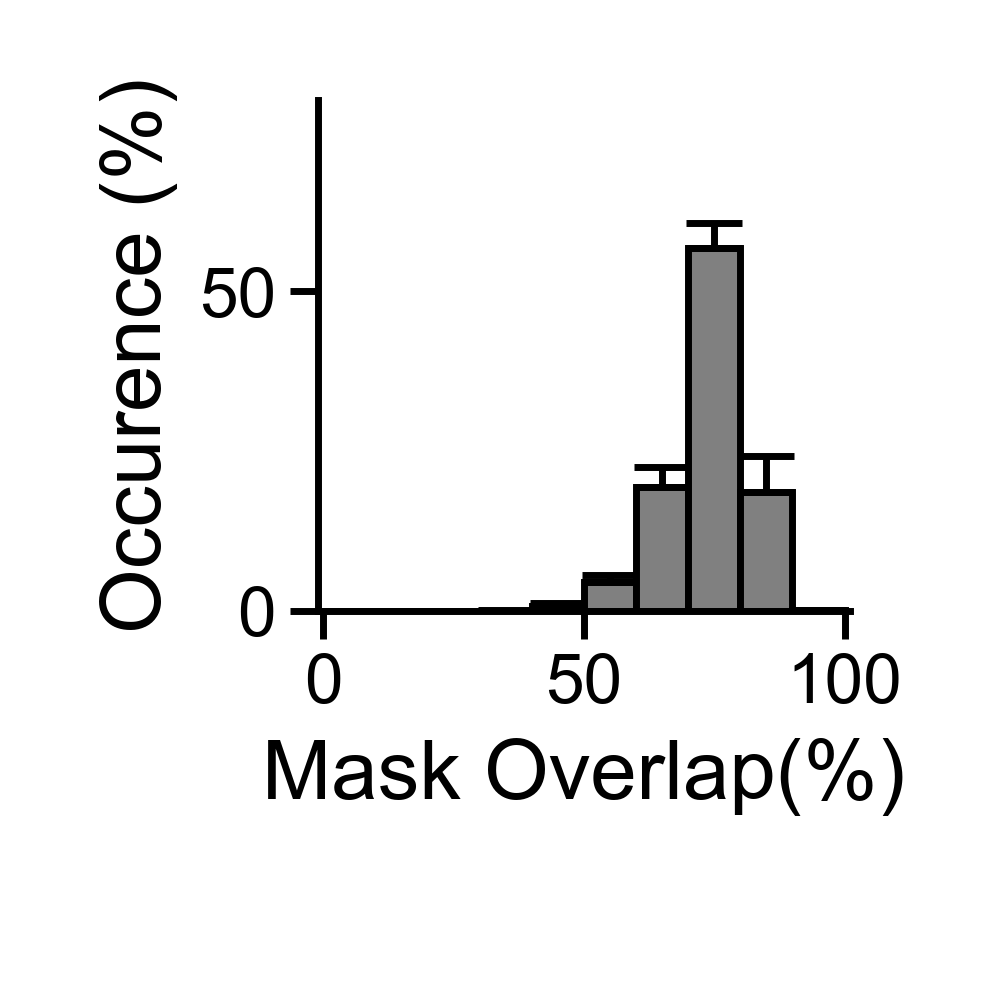

In [6]:
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(22.5/25.4 ,22.5/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['plot'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1],
)
ax = axs['plot']
x_pos = np.arange(0+(bin_size/2), 100,bin_size)
ax.bar(x_pos, result_m,width=bin_size/1, color='gray',edgecolor='black',linewidth=0.5)
y_err = np.array([ [0,err] for err in result_std]).T
ax.errorbar(x_pos,result_m,
           yerr = y_err,fmt='none',solid_capstyle='projecting',
            capsize=2,color='black',capthick=0.5,elinewidth=0.5)
# set x ticks
ax.set_xticks(np.arange(0,101,50))
ax.set_xlim(-1,101)
ax.set_xlabel('Mask Overlap(%)\n')
ax.set_ylabel('Occurence (%)')
# text

# Appendix: Sanity check numbering of template masks
Template masks length does not match matched masks size due to filtering on size

In [7]:
# plotting some example data.
for info in matched_info:
    print(info['animal'])
    print(f'number matched masks: {len(info["matched_masks"])}')
    print(f'number template masks: {len(info["template_masks"])}')
    # Note! number of templates does not match number of clustered masks.
    id =1 
    mismatch_count = 0
    for mask in info['template_masks']:
        if id !=mask['id']:
            mismatch_count+=mask['id']-id
            id=mask['id']
        id+=1
    print(f'Number of mismatched masks: {mismatch_count}')


A4
number matched masks: 4206
number template masks: 3906
Number of mismatched masks: 300
A5
number matched masks: 4670
number template masks: 4254
Number of mismatched masks: 416
A7
number matched masks: 5738
number template masks: 5354
Number of mismatched masks: 384
B2
number matched masks: 3290
number template masks: 3034
Number of mismatched masks: 256
B3
number matched masks: 4416
number template masks: 4240
Number of mismatched masks: 176
B4
number matched masks: 5351
number template masks: 4924
Number of mismatched masks: 427
B5
number matched masks: 3472
number template masks: 3385
Number of mismatched masks: 87
C1
number matched masks: 4005
number template masks: 3812
Number of mismatched masks: 193
D1
number matched masks: 3707
number template masks: 3581
Number of mismatched masks: 126
F1
number matched masks: 3781
number template masks: 3498
Number of mismatched masks: 283
F5
number matched masks: 3965
number template masks: 3508
Number of mismatched masks: 457
